In [1]:
%matplotlib notebook
import os
import bvhsdk
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
matplotlib.rc('animation', html='html5')

In [2]:
from ipywidgets import interact, interactive, widgets
from IPython.display import display

In [3]:
bvhspath = './save/6_ptbr/samples_6_ptbr_000600000_seed10'
files = [os.path.join(bvhspath,file) for file in os.listdir(bvhspath) if file.endswith('.bvh')]
files.sort()
bvhsgt = './dataset/PTBRGestures/motion/bvh_twh'
filesgt = [os.path.join(bvhsgt,file) for file in os.listdir(bvhsgt) if file.endswith('.bvh')]
filesgt.sort()

<IPython.core.display.Javascript object>


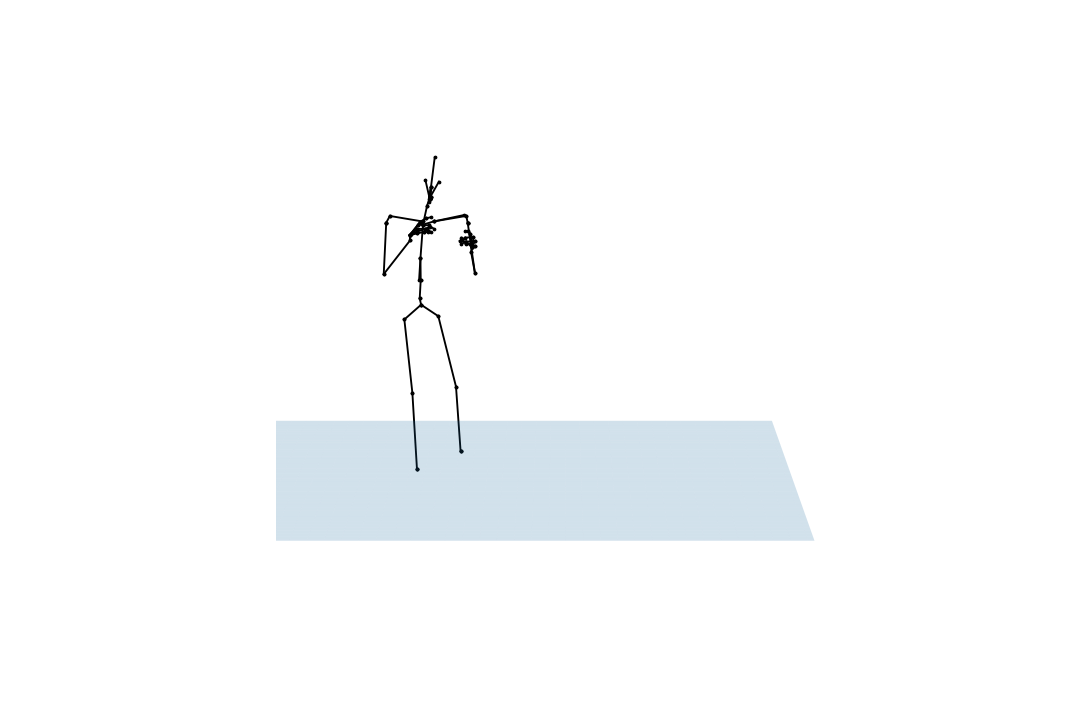

Precomputing positions...


In [4]:
anim = bvhsdk.ReadFile(files[1])
ani = bvhsdk.plotanimation.plot3d(anim, skiproot=2, frameDelay=5)

In [4]:
class Grid:
    def __init__(self, 
                 grange=200, 
                 gstep=1):
        self.grange = grange
        self.gstep = gstep
        self.grid = self.create_grid()
        
    def create_grid(self):
        size = int(self.grange/self.gstep)
        return [[0] * size for _ in range(size)]

def bresenham_line(x0, y0, x1, y1, 
                   grid,
                   grange,
                   gstep,
                   weigth=1):
    grid_size = len(grid)
    
    x0 = int(np.rint(x0 * 1/gstep))
    y0 = int(np.rint(y0 * 1/gstep))
    x1 = int(np.rint(x1 * 1/gstep))
    y1 = int(np.rint(y1 * 1/gstep))
    
    # Ensure the endpoints are within the grid bounds
    x0, y0 = max(0, min(grid_size - 1, x0)), max(0, min(grid_size - 1, y0))
    x1, y1 = max(0, min(grid_size - 1, x1)), max(0, min(grid_size - 1, y1))
    
    # Bresenham's line algorithm
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        # Mark the current grid cell as filled
        grid[grid_size - 1 - y0][x0] += weigth 
                      
        if x0 == x1 and y0 == y1:
            break
        
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    
    return grid

def add_to_grid(grid,
                grange,
                gstep,
                anim, 
                frame=0, 
                xaxis=0, 
                yaxis=1, 
                weigth=1):
    parents = anim.arrayParent()
    joint_positions = np.asarray([joint.getPosition(frame) for joint in anim.getlistofjoints()])
    for i in range(2,len(parents)):
        grid = bresenham_line(
                                joint_positions[parents[i]][xaxis] + 100,
                                joint_positions[parents[i]][yaxis],
                                joint_positions[i][xaxis] + 100,
                                joint_positions[i][yaxis],
                                grid=grid,
                                grange=grange,
                                gstep=gstep,
                                weigth=weigth,
        )
    return grid

def rasterize(anim, 
              xaxis=0, 
              yaxis=1, 
              weigth=0.1, 
              frame_skip=5,
              grid_range=200,
              grid_step=0.5):
    grid = Grid(grange=grid_range, gstep=grid_step)
    for i in range(0, anim.frames, frame_skip):
        grid.grid = add_to_grid(grid.grid,
                                grid.grange,
                                grid.gstep,
                                anim, 
                                frame = i, 
                                xaxis=xaxis, 
                                yaxis=yaxis, 
                                weigth=weigth)
    return grid

In [48]:
def plotPose(anim, 
             frame = 0, 
             fig=None, 
             ax=None, 
             color='black', 
             alpha=1, 
             xaxis=0, 
             yaxis=1, 
             xlims=[-100,100], 
             ylims=[0,200], 
             sfj=1,
             norm=plt.Normalize(vmin=-10, vmax=10, clip=True),
             colorMap=plt.cm.gnuplot,
             **kwargs,
            ):
    """
    sfj: skip first joints
    """
    parents = anim.arrayParent()
    joint_positions = np.asarray([joint.getPosition(frame) for joint in anim.getlistofjoints()]) # (joints, 3)
    joint_vel = joint_positions - np.asarray([joint.getPosition(frame-1) for joint in anim.getlistofjoints()]) if frame > 0 else np.zeros(shape=joint_positions.shape)
    joint_vel = np.sum(np.abs(joint_vel), axis = 1)
    if not fig or not ax:
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
    for i in range(1+sfj,len(parents)):
        x = [joint_positions[parents[i]][xaxis], joint_positions[i][xaxis]]
        y = [joint_positions[parents[i]][yaxis], joint_positions[i][yaxis]]
        plt.plot(x, y, c=colorMap(norm(joint_vel[parents[i]])), alpha=alpha)
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_ylim(ylims[0],ylims[1])
    
    return fig, ax

def plotAnim(path, **kwargs):
    anim = bvhsdk.ReadFile(path)
    if kwargs.pop('skipRootTranslation', False):
        anim.root.translation = np.zeros(shape=anim.root.translation.shape)
    fig = plt.figure(figsize = kwargs.pop('figSize', (12,8)))
    ax = fig.add_subplot(111)
    title = kwargs.pop('title', os.path.basename(path))
    plotBegin, plotEnd, step = kwargs.pop('plotBegin', 0), kwargs.pop('plotEnd', anim.frames), kwargs.pop('step', 5)
    for i in range(plotBegin, plotEnd, step):
        fig, ax = plotPose(anim, frame=i, fig=fig, ax=ax, **kwargs)
    ax.set_title("{}".format(title))
    if kwargs.pop('savefig', False):
        fname = kwargs.pop('fname', os.path.basename(path)+'.png')
        plt.savefig(fname=fname)
    return fig, ax
    
    

<IPython.core.display.Javascript object>


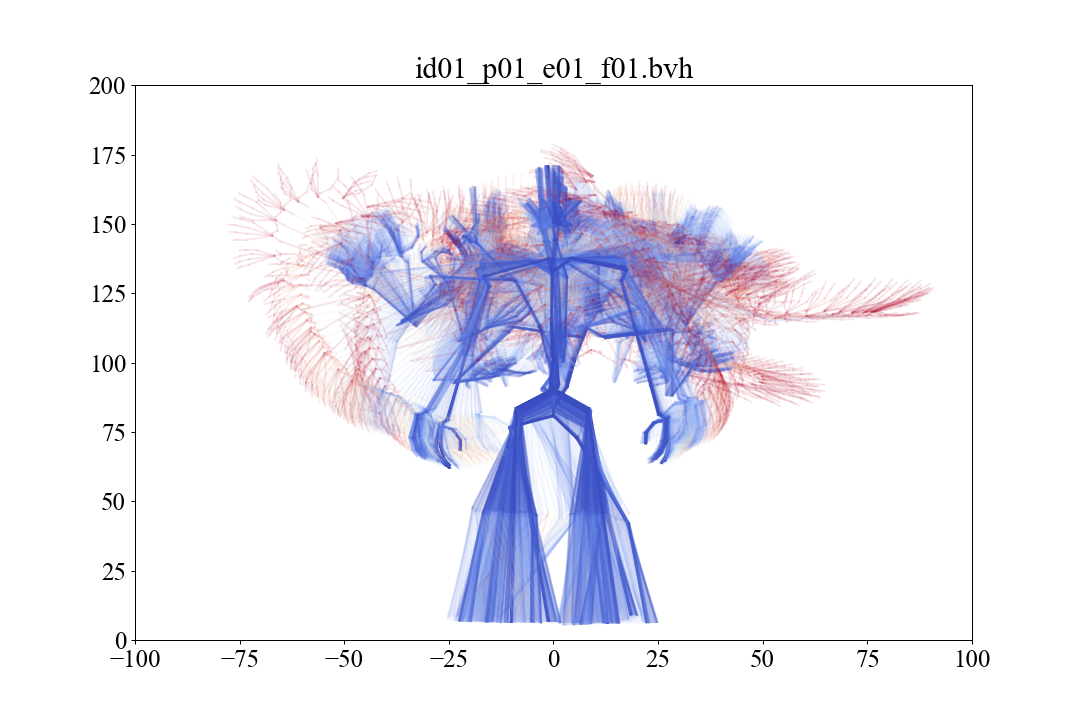

In [55]:
idx = 0
gen = files[idx]
gt = os.path.join(os.path.dirname(filesgt[0]), os.path.basename(gen).replace('gen_', ''))

fig, ax = plotAnim(gt, 
                       alpha=0.1, 
                       colorMap=plt.cm.coolwarm, 
                       norm=plt.Normalize(vmin=0, vmax=5, clip=True),
                       step=1,
                       skipRootTranslation=True,
                       #savefig=True,
                       #fname='./gesture_space/'+os.path.basename(gen).replace('.bvh', '.png'),
                      )

<IPython.core.display.Javascript object>


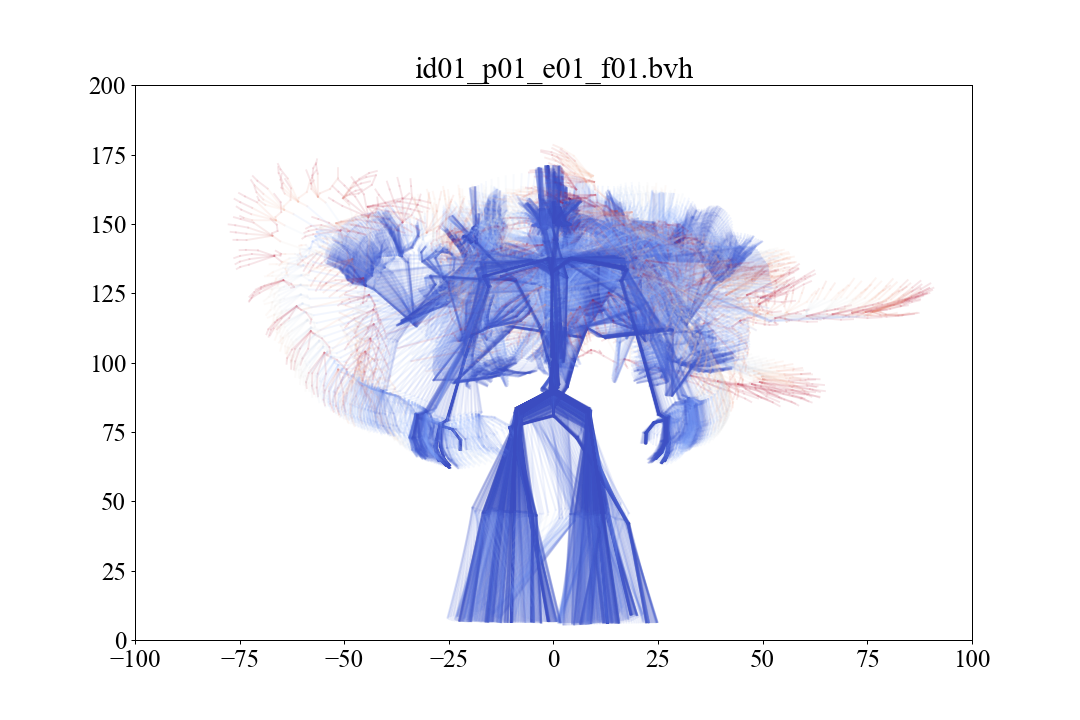

In [54]:
idx = 0
gen = files[idx]
gt = os.path.join(os.path.dirname(filesgt[0]), os.path.basename(gen).replace('gen_', ''))

fig, ax = plotAnim(gt, 
                       alpha=0.1, 
                       colorMap=plt.cm.coolwarm, 
                       norm=plt.Normalize(vmin=0, vmax=10, clip=True),
                       step=1,
                       skipRootTranslation=True,
                       #savefig=True,
                       #fname='./gesture_space/'+os.path.basename(gen).replace('.bvh', '.png'),
                      )

<IPython.core.display.Javascript object>


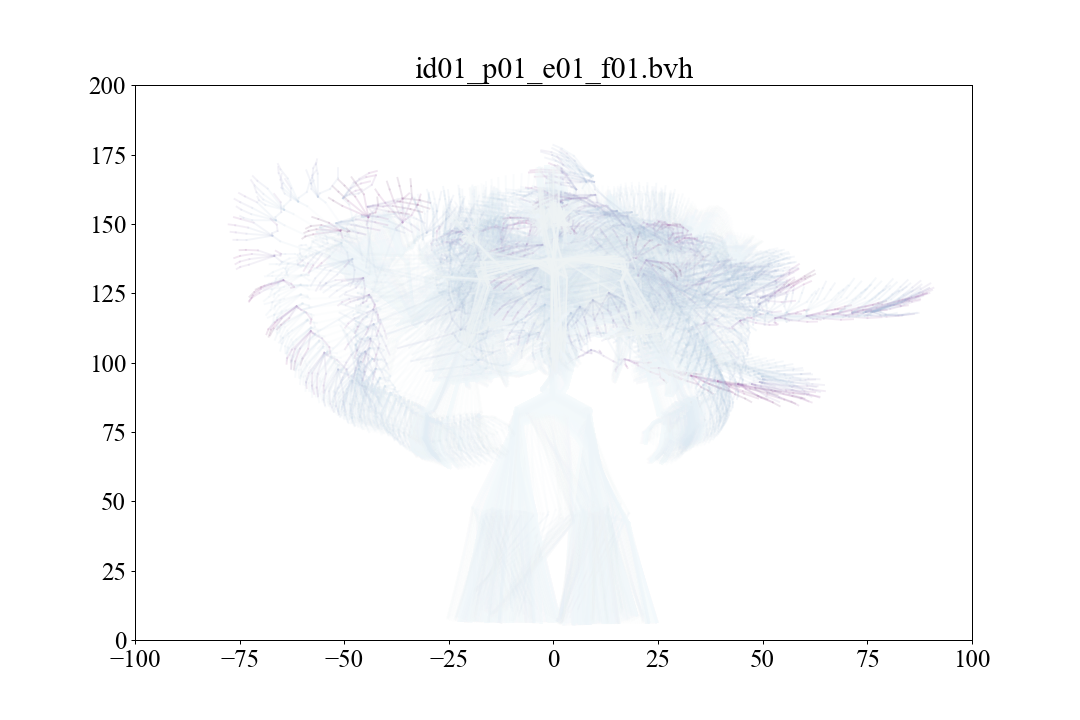

In [51]:
idx = 0
for idx in range(len(files)):
    gen = files[idx]
    gt = os.path.join(os.path.dirname(filesgt[0]), os.path.basename(gen).replace('gen_', ''))

    fig, ax = plotAnim(gen, 
                       alpha=0.1, 
                       colorMap=plt.cm.BuPu, 
                       norm=plt.Normalize(vmin=0, vmax=20, clip=True),
                       step=1,
                       skipRootTranslation=True,
                       savefig=True,
                       fname='./gesture_space/'+os.path.basename(gen).replace('.bvh', '.png'),
                      )
    
    fig, ax = plotAnim(gt, 
                       alpha=0.1, 
                       colorMap=plt.cm.BuPu, 
                       norm=plt.Normalize(vmin=0, vmax=20, clip=True),
                       step=1,
                       skipRootTranslation=True,
                       savefig=True,
                       fname='./gesture_space/'+os.path.basename(gt).replace('.bvh', '.png'),
                      )

<IPython.core.display.Javascript object>


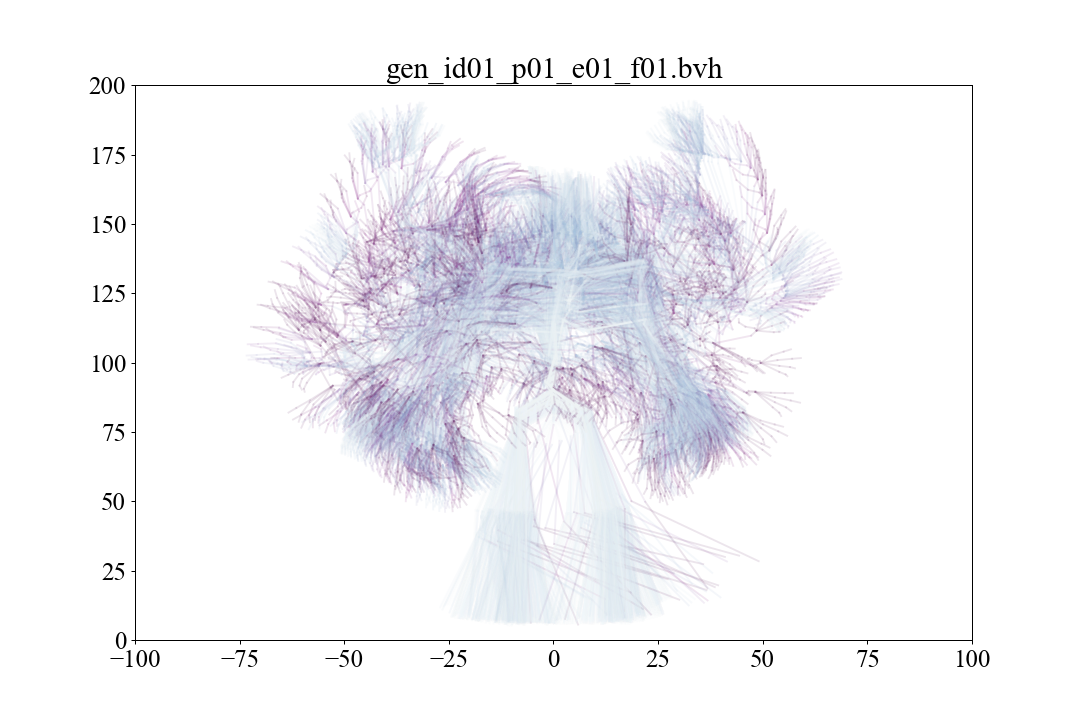

<IPython.core.display.Javascript object>


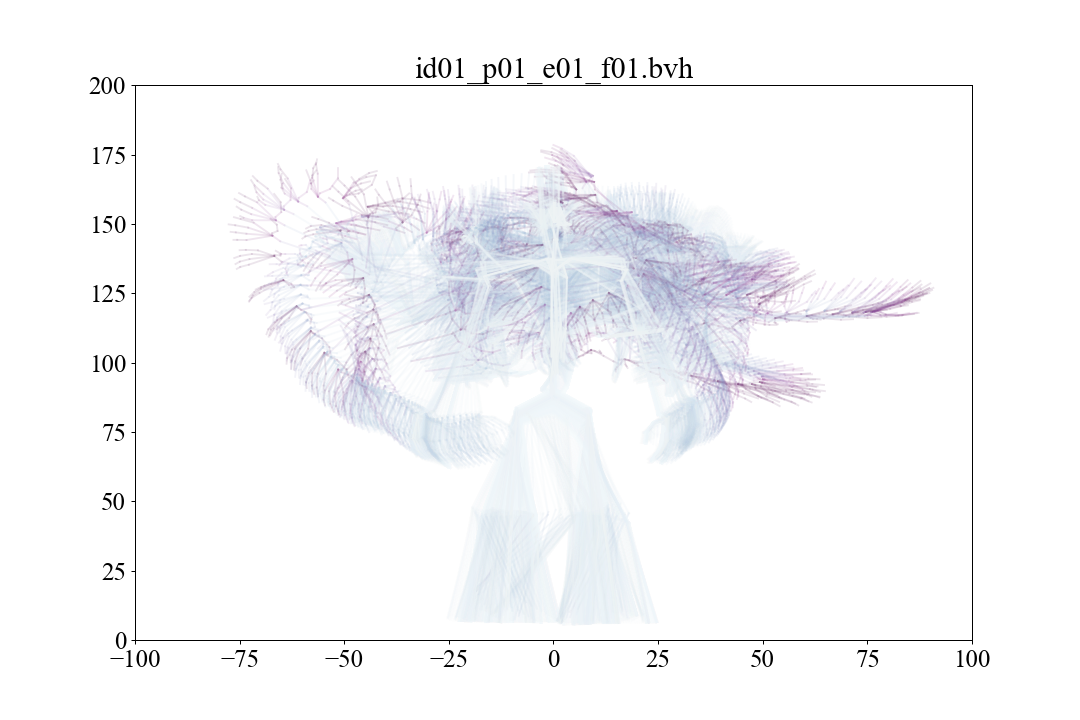

In [38]:
idx = 0
gen = files[idx]
gt = os.path.join(os.path.dirname(filesgt[0]), os.path.basename(gen).replace('gen_', ''))
step = 1

anim = bvhsdk.ReadFile(gen)
anim.root.translation = np.zeros(shape=anim.root.translation.shape)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(0, anim.frames, step):
    fig, ax = plotPose(anim, 
                       frame=i,
                       fig=fig,
                       ax=ax,
                       alpha=0.1,
                       #colorMap=plt.cm.Greys,
                       colorMap=plt.cm.BuPu,
                       norm= plt.Normalize(vmin=0, vmax=10, clip=True)
                       ,)
ax.set_title("{}".format(os.path.basename(gen)))
plt.savefig(fname=)

anim = bvhsdk.ReadFile(gt)
anim.root.translation = np.zeros(shape=anim.root.translation.shape)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(0, anim.frames, step):
    fig, ax = plotPose(anim, 
                       frame=i,
                       fig=fig,
                       ax=ax,
                       alpha=0.1,
                       #colorMap=plt.cm.Greys,
                       colorMap=plt.cm.BuPu,
                       norm= plt.Normalize(vmin=0, vmax=10, clip=True)
                       ,)
ax.set_title("{}".format(os.path.basename(gt)))

anim = bvhsdk.ReadFile(gen)
#anim.root.translation = np.zeros(shape=anim.root.translation.shape)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(0, anim.frames, step):
    fig, ax = plotPose(anim, 
                       frame=i,
                       fig=fig,
                       ax=ax,
                       alpha=0.1,
                       #colorMap=plt.cm.Greys,
                       colorMap=plt.cm.BuPu,
                       norm= plt.Normalize(vmin=0, vmax=10, clip=True)
                       ,)
ax.set_title("{}".format(os.path.basename(gen)))

anim = bvhsdk.ReadFile(gt)
#anim.root.translation = np.zeros(shape=anim.root.translation.shape)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(0, anim.frames, step):
    fig, ax = plotPose(anim, 
                       frame=i,
                       fig=fig,
                       ax=ax,
                       alpha=0.1,
                       #colorMap=plt.cm.Greys,
                       colorMap=plt.cm.BuPu,
                       norm= plt.Normalize(vmin=0, vmax=10, clip=True)
                       ,)
ax.set_title("{}".format(os.path.basename(gt)))

In [14]:
(filesgt[0])

'./dataset/PTBRGestures/motion/bvh_twh'

0/848
./save/6_ptbr/samples_6_ptbr_000600000_seed10\gen_id01_p01_e01_f01.bvh


<IPython.core.display.Javascript object>


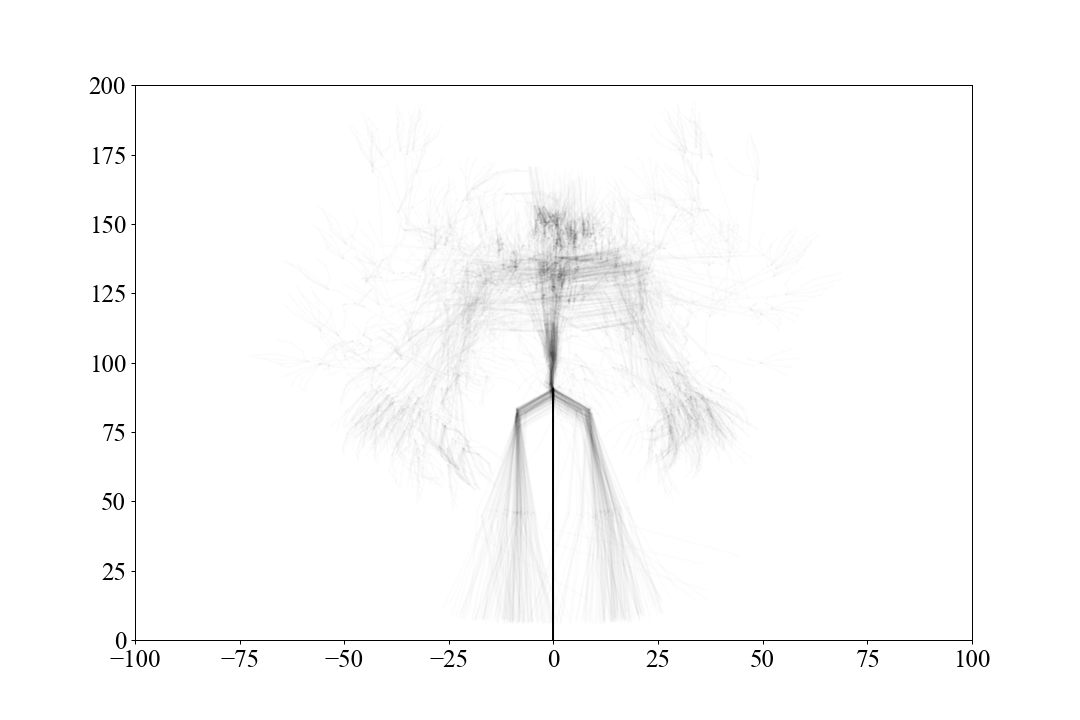

<IPython.core.display.Javascript object>


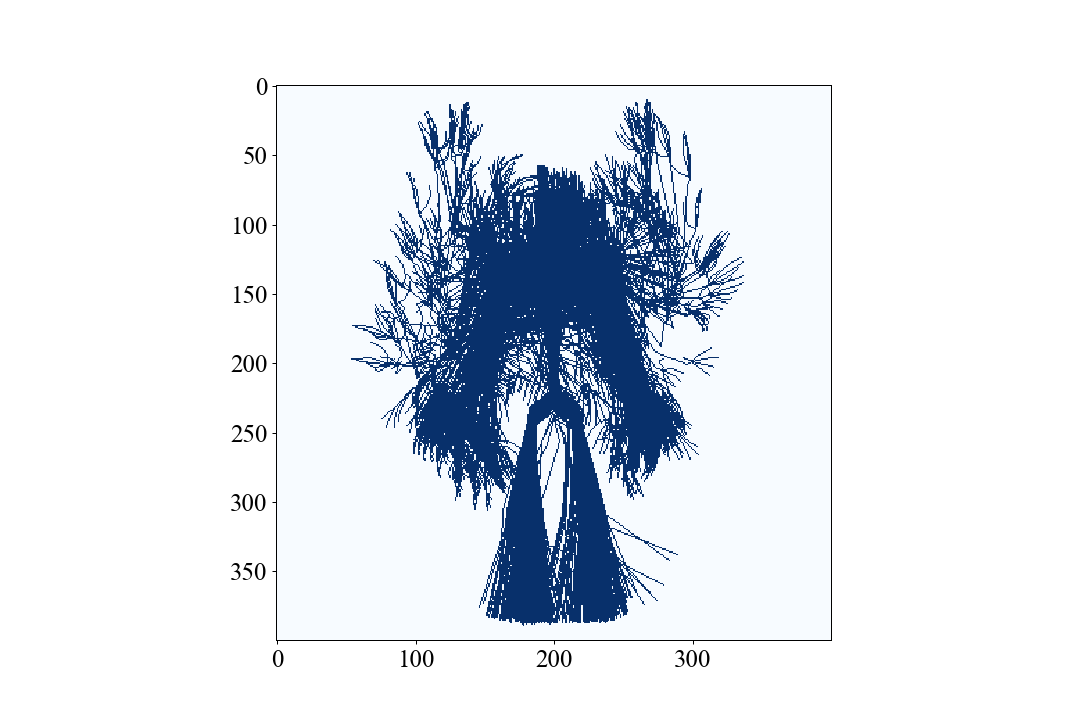

In [8]:
figpath = './spacefigs/poses'
rasterpath = './spacefigs/raster'
for i, file in enumerate(files + filesgt):
    print('{}/{}'.format(i, len(files)+len(filesgt)))
    print(file)
    anim = bvhsdk.ReadFile(file)
    anim.root.translation = np.zeros(shape=anim.root.translation.shape)
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    for i in range(0, anim.frames, 5):
        fig, ax = plotPose(anim, frame=i, fig=fig, ax=ax, alpha=0.01)
    #plt.savefig(fname=os.path.join(figpath, os.path.basename(file)[:-4]))
    #plt.close(fig)
    
    grid = rasterize(anim, frame_skip=3, grid_step=0.5, weigth=1)
    grid.clipped = np.clip(grid.grid, 0, 1)
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.imshow(grid.clipped, cmap='Blues', interpolation='nearest')
    plt.show()
    break
    #plt.savefig(fname=os.path.join(rasterpath, os.path.basename(file)[:-4]))
    #plt.close(fig)

In [37]:
positions = [joint.getPosition(frame) for frame in range(anim.frames) for joint in anim.getlistofjoints()]
positions = np.reshape(np.asarray(positions), newshape = (anim.frames, len(anim.getlistofjoints()), 3))

In [34]:
for i, joint in enumerate(anim.getlistofjoints()):
    print(i, joint.name)

0 body_world
1 b_root
2 b_spine0
3 b_spine1
4 b_spine2
5 b_spine3
6 b_neck0
7 b_head
8 b_head_null
9 b_l_eye
10 b_r_eye
11 b_jaw
12 b_jaw_null
13 b_teeth
14 b_tongue0
15 b_tongue1
16 b_tongue2
17 b_tongue3
18 b_tongue4
19 b_l_tongue4_1
20 b_r_tongue4_1
21 b_l_tongue3_1
22 b_r_tongue3_1
23 b_l_tongue2_1
24 b_r_tongue2_1
25 b_r_tongue1_1
26 b_l_tongue1_1
27 b_r_shoulder
28 p_r_scap
29 b_r_arm
30 b_r_arm_twist
31 b_r_forearm
32 b_r_wrist_twist
33 b_r_wrist
34 b_r_index1
35 b_r_index2
36 b_r_index3
37 b_r_ring1
38 b_r_ring2
39 b_r_ring3
40 b_r_middle1
41 b_r_middle2
42 b_r_middle3
43 b_r_pinky1
44 b_r_pinky2
45 b_r_pinky3
46 b_r_thumb0
47 b_r_thumb1
48 b_r_thumb2
49 b_r_thumb3
50 b_l_shoulder
51 p_l_delt
52 p_l_scap
53 b_l_arm
54 b_l_arm_twist
55 b_l_forearm
56 b_l_wrist_twist
57 b_l_wrist
58 b_l_thumb0
59 b_l_thumb1
60 b_l_thumb2
61 b_l_thumb3
62 b_l_index1
63 b_l_index2
64 b_l_index3
65 b_l_middle1
66 b_l_middle2
67 b_l_middle3
68 b_l_ring1
69 b_l_ring2
70 b_l_ring3
71 b_l_pinky1
72 b_l_

In [35]:
teste[:,57,:]

array([[28.01376347, 81.38725276,  1.49275454],
       [27.92740599, 81.32930475,  1.4073811 ],
       [27.91816149, 81.31173213,  1.33472657],
       ...,
       [29.9216751 , 83.92203557, -4.58739707],
       [30.08463973, 83.91290391, -4.91459639],
       [30.14122181, 83.83719193, -4.78695672]])

<IPython.core.display.Javascript object>


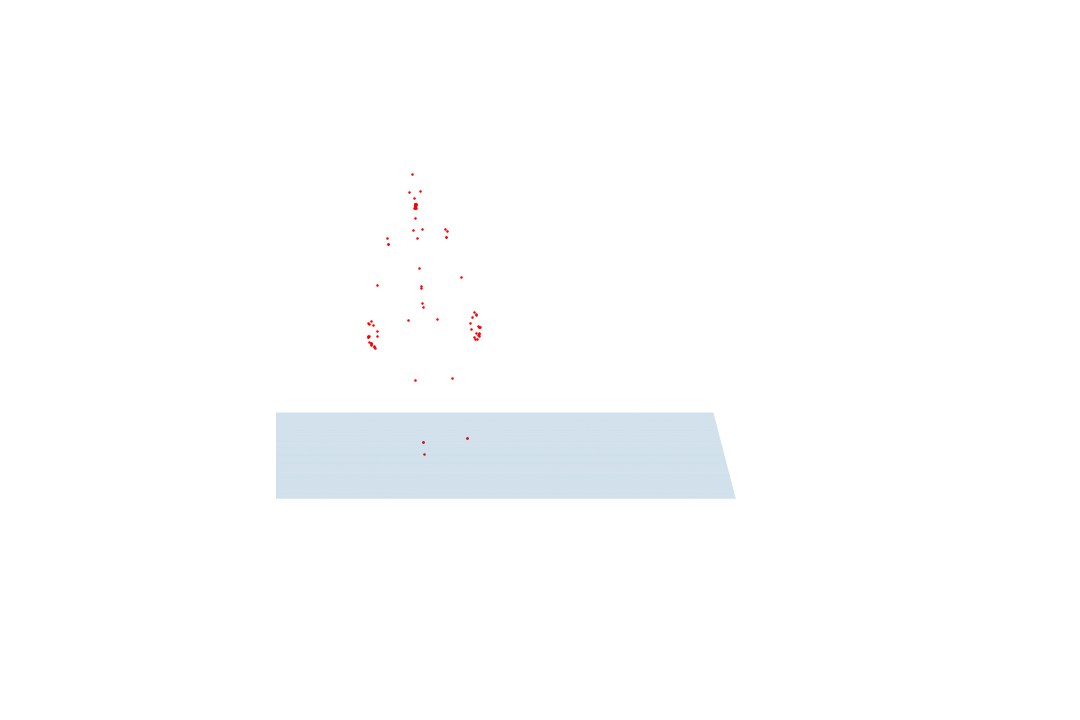

Precomputing positions...


In [30]:
def PlotBVH(animation, 
            frameDelay = 0, 
            precompute = True, 
            viewPlane = 0,
            floorPlane = True,
            ):
    """
    Plot BVH animation joints as point cloud. Currently assumes Y-up character.
    Works better if precompute is True.
    Calculate the position inside this funtion.
    Ipython Jupyter Notebook-friendly function.

    Make sure to include the following line in your notebook:
    %matplotlib notebook
    import matplotlib
    matplotlib.rc('animation', html='html5')

    These lines may also be necessary:
    from ipywidgets import interact, interactive, widgets
    from IPython.display import display
    
    :param anim.Animation animation: Animation object to be draw
    :param int frameDelay: Interval or delay between frames of matplotlib's FuncAnimation function in miliseconds. If 0, use animation's frametime to match intended fps from BVH file.
    :param int viewPlane: Primary view plane option (choose between 1 and )
    :param bool precompute: If True, the function will precompute the positions of the joints. If False, the function will calculate the position of the joints at each frame.
    """
    def update(frame, scatters, precomp_positions):
        for scat, joint, i in zip(scatters, animation.getlistofjoints(), range(len(animation.getlistofjoints()))):
            if precompute:
                position = precomp_positions[frame, i]
            else:
                position = joint.getPosition(frame)
            scat.set_data([position[0]],[position[1]])
            scat.set_3d_properties([position[2]])

        return scatters

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
        
    precomp_positions = None
    if precompute:
        print('Precomputing positions...')
        precomp_positions = [joint.getPosition(frame) for frame in range(animation.frames) for joint in animation.getlistofjoints()]
        precomp_positions = np.reshape(np.asarray(precomp_positions), newshape = (animation.frames, len(animation.getlistofjoints()), 3))
        
    frameDelay = int(animation.frametime * 1000) if frameDelay == 0 else frameDelay

    scatters = []
    maxdata = -np.inf
    mindata = np.inf
    for i, joint in enumerate(animation.getlistofjoints()):
        if precompute:
            position = precomp_positions[0, i]
        else:
            position = joint.getPosition(frame = 0)
        scatters.append(ax.plot([position[0]],[position[1]],[position[2]],'o', color='red', markersize=1)[0])
        if np.min(position)<mindata:
            mindata = np.min(position)
        if np.max(position)>maxdata:
            maxdata = np.max(position)      
            
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(mindata,maxdata)
    ax.set_ylim(mindata,maxdata)
    ax.set_zlim(mindata,maxdata)
    
    # Draw floor plane
    if floorPlane:
        
        sx, sz = np.meshgrid(range(-int(maxdata), int(maxdata)), range(-int(maxdata), int(maxdata)))
        sy = np.zeros(shape=sx.shape)
        ax.plot_surface(sx, sy, sz, alpha=0.2)
    
    # Set initial view direction
    if viewPlane:
        # (plane, (elev, azim, roll))
        views = [('XY',   (90, -90, 0)),
                 ('XZ',    (0, -90, 0)),
                 ('YZ',    (0,   0, 0)),
                 ('-XY', (-90,  90, 0)),
                 ('-XZ',   (0,  90, 0)),
                 ('-YZ',   (0, 180, 0))]
        angles = views[viewPlane - 1][1]
        ax.view_init(elev=angles[0], azim=angles[1])
    else:
        ax.view_init(elev=100, azim=-90)
        
    ax.grid(False)
    ax.axis('off')
    
    ani = FuncAnimation(fig, update, frames=np.arange(animation.frames), fargs=([scatters, precomp_positions]) ,interval=frameDelay, blit=True)
    plt.show()
    return ani

anim = bvhsdk.ReadFile(files[0])
ani = PlotBVH(anim)

Precomputing joint positions...
(620, 83, 3)


<IPython.core.display.Javascript object>


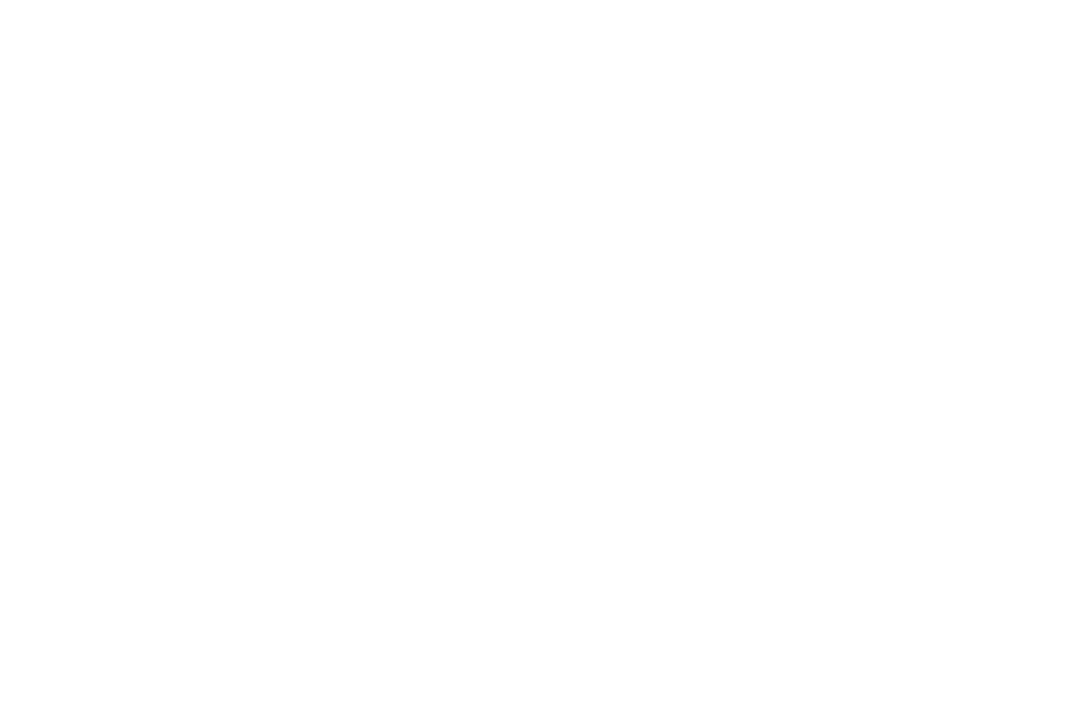

In [4]:
def AnimPlotBones(animation, xaxis=0, color='black', frameDelay = 0, viewPlane = 0,floorPlane = True, skiproot = 0, dist=7):

    def update(frame, lines, precomp_positions, parents):
        for line, i in zip(lines, range(len(parents)-len(lines), len(parents))): # This range is to account for skiproot
            x = [precomp_positions[frame, parents[i], 0], precomp_positions[frame, i, 0]]
            y = [precomp_positions[frame, parents[i], 1], precomp_positions[frame, i, 1]]
            z = [precomp_positions[frame, parents[i], 2], precomp_positions[frame, i, 2]]
            line.set_data(x,y)
            line.set_3d_properties(z)
        return lines

    print('Precomputing joint positions...')
    precomp_positions = [joint.getPosition(frame) for frame in range(animation.frames) for joint in animation.getlistofjoints()]
    precomp_positions = np.reshape(np.asarray(precomp_positions), newshape = (animation.frames, len(animation.getlistofjoints()), 3))
    # precomp_positions shape: (frames, joints, xyz)
    print(precomp_positions.shape)
    
    mindata = np.min(precomp_positions)
    maxdata = np.max(precomp_positions)
    
    frameDelay = int(animation.frametime * 1000) if frameDelay == 0 else frameDelay
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    
    parents = anim.arrayParent()
    
    lines = []
    for i in range(skiproot, len(parents)):
        x = [precomp_positions[0, parents[i], 0], precomp_positions[0 , i, 0]]
        y = [precomp_positions[0, parents[i], 1], precomp_positions[0 , i, 1]]
        z = [precomp_positions[0, parents[i], 2], precomp_positions[0 , i, 2]]
        lines.append(ax.plot(x, y, z, marker='o', linestyle='-', markersize=2, c=color)[0])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(mindata,maxdata)
    ax.set_ylim(mindata,maxdata)
    ax.set_zlim(mindata,maxdata)    
    
    ani = FuncAnimation(fig, update, frames=np.arange(animation.frames), fargs=([lines, precomp_positions, parents]),
                        interval=frameDelay, blit=True)
    
    # Draw floor plane
    if floorPlane:
        
        sx, sz = np.meshgrid(range(-int(maxdata), int(maxdata)), range(-int(maxdata), int(maxdata)))
        sy = np.zeros(shape=sx.shape)
        ax.plot_surface(sx, sy, sz, alpha=0.2)
    
    # Set initial view direction
    if viewPlane:
        # (plane, (elev, azim, roll))
        views = [('XY',   (90, -90, 0)),
                 ('XZ',    (0, -90, 0)),
                 ('YZ',    (0,   0, 0)),
                 ('-XY', (-90,  90, 0)),
                 ('-XZ',   (0,  90, 0)),
                 ('-YZ',   (0, 180, 0))]
        angles = views[viewPlane - 1][1]
        ax.view_init(elev=angles[0], azim=angles[1])
    else:
        ax.view_init(elev=100, azim=-90)
        
    if dist:
        ax.dist=dist
        
    ax.grid(False)
    ax.axis('off')
    
    plt.show()
    return ani

anim = bvhsdk.ReadFile(files[1])
ani = AnimPlotBones(anim, skiproot=2, frameDelay=10)